<a href="https://www.kaggle.com/code/ericmutisya/lr-lassocv-ensemble-feature-selection-eda?scriptVersionId=140985710" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/insurance/insurance.csv


In [2]:
df = pd.read_csv('/kaggle/input/insurance/insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
df.shape

(1338, 7)

In [4]:
df[df.duplicated()]

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


In [5]:
df.drop_duplicates(inplace = True)

In [6]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [7]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [8]:
x = df.drop('charges', axis = 1)
y = df['charges']

In [9]:
x.describe()

,age,bmi,children
count,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737
std,14.044333,6.100468,1.205571
min,18.000000,15.960000,0.000000
25%,27.000000,26.290000,0.000000
50%,39.000000,30.400000,1.000000
75%,51.000000,34.700000,2.000000
max,64.000000,53.130000,5.000000


We will have to scale this dataset.

In [10]:
x.describe(exclude = 'number')

,sex,smoker,region
count,1337,1337,1337
unique,2,2,4
top,male,no,southeast
freq,675,1063,364


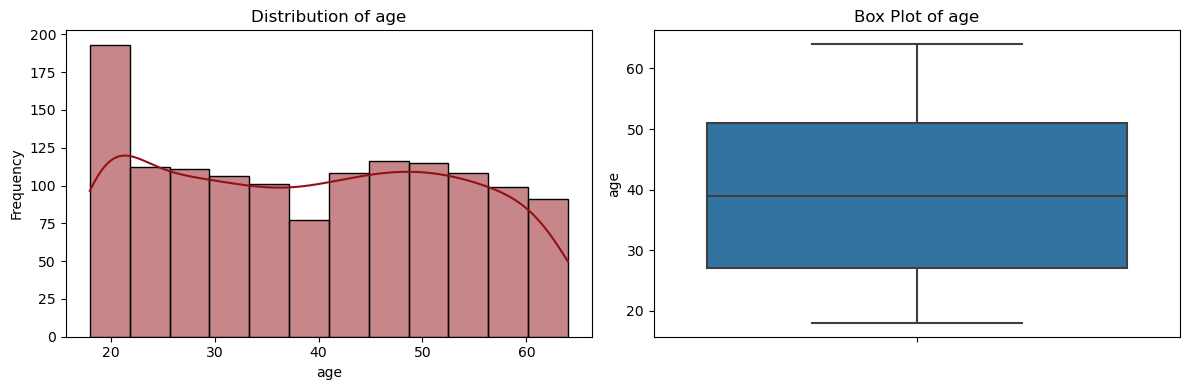

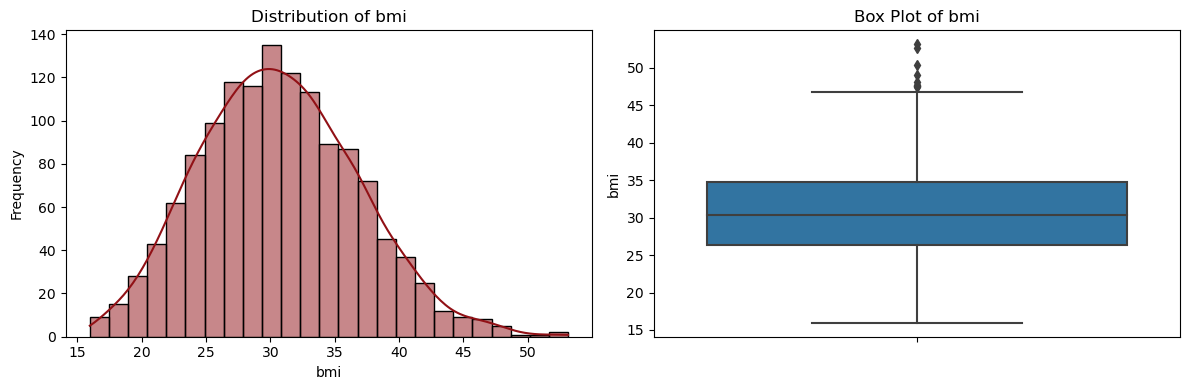

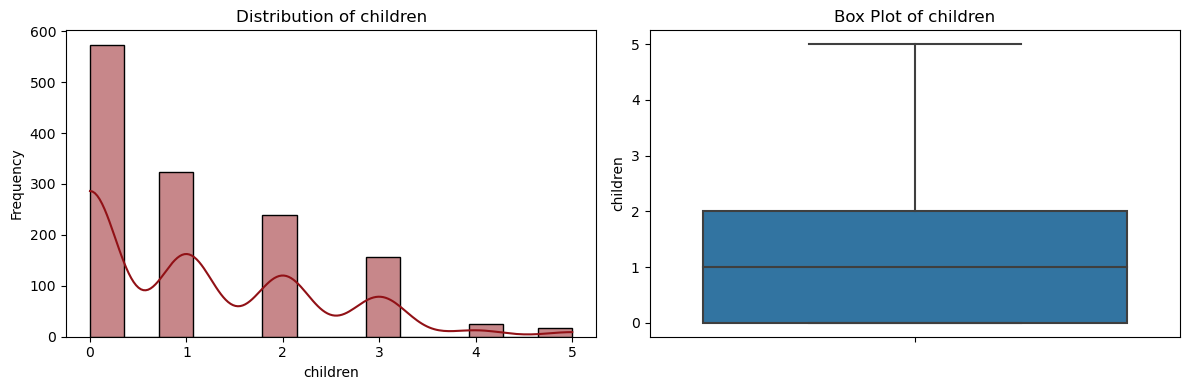

In [11]:
for column in x.columns:    
    if x[column].dtype != 'object':
        plt.figure(figsize=(12, 4))
        # Defining subplots in one row and two columns
        # In index one of the subplot, we will have histogram
        plt.subplot(1,2,1)
        sns.histplot(data=x, x=column, kde=True, color = '#911116', line_kws={'color': '#911156'})
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.title(f'Distribution of {column}')
        # The second index subplot will have boxplots
        plt.subplot(1,2,2)
        sns.boxplot(data=x, y=column)
        plt.ylabel(column)
        plt.title(f'Box Plot of {column}')
        # To make sure that no overlapping 
        plt.tight_layout()
        plt.show()

Only the distribution for BMI resembles a normal distribution.

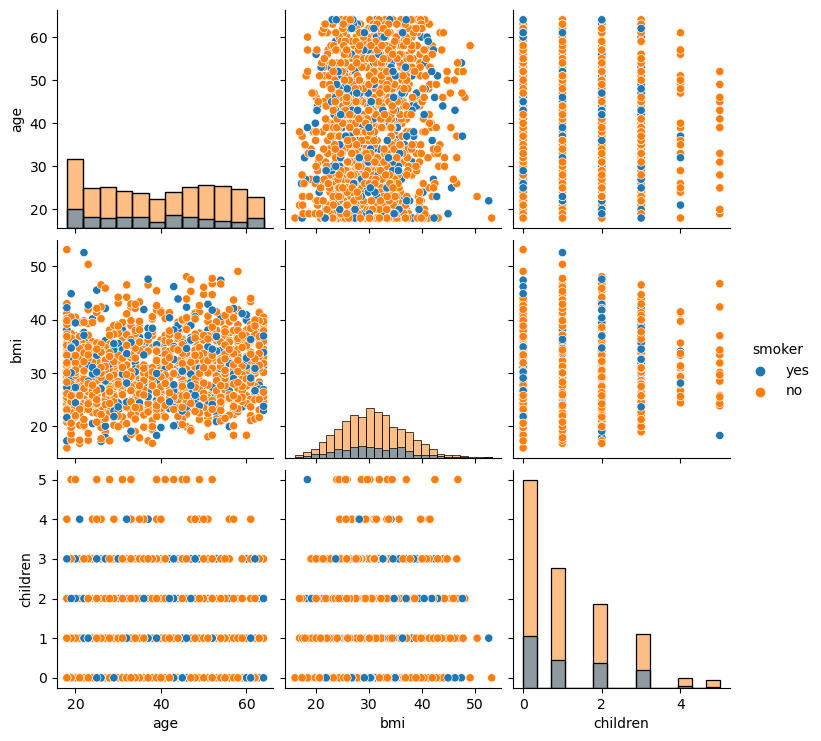

In [12]:
sns.pairplot(x, hue = 'smoker', diag_kind = 'hist')
plt.show()

We don't see any strongly correlated features.

### Correlation

In [13]:
x.corr()

,age,bmi,children
age,1.000000,0.109344,0.041536
bmi,0.109344,1.000000,0.012755
children,0.041536,0.012755,1.000000


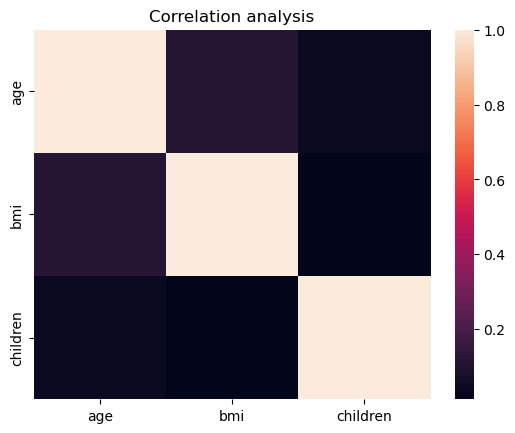

In [14]:
sns.heatmap(x.corr())
plt.title('Correlation analysis')
plt.show()

### Outliers

Lets get rid of outliers statistically.

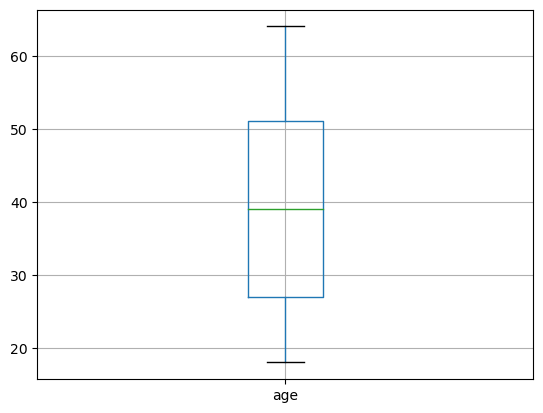

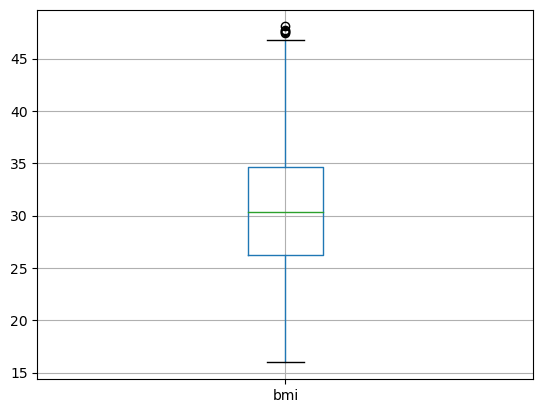

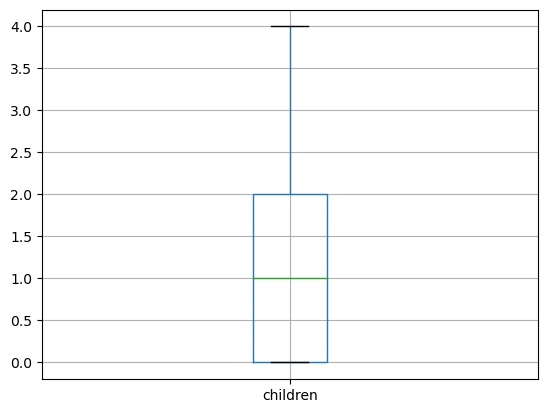

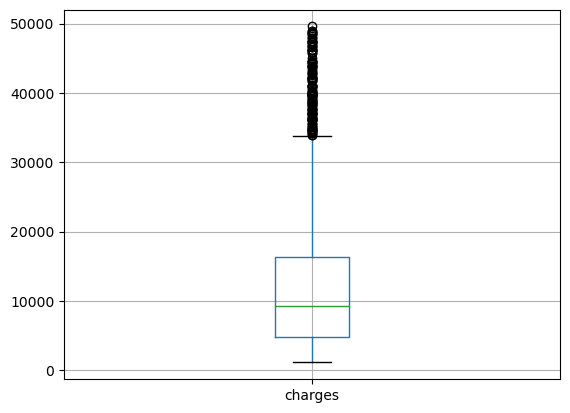

Observations after statistically removing outliers 1330, which means that 7 observations have been dropped


In [15]:
for col in df.columns:
    if df[col].dtypes != 'object':
        std = df[col].std()
        mean = df[col].mean()
        cut_off = std * 3
        lower, upper = mean - cut_off, mean + cut_off
        new_df = df[(df[col] < upper) \
                           & (df[col] > lower)]
        new_df[[col]].boxplot()
        plt.show()
print(f'Observations after statistically removing outliers {new_df.shape[0]}, which means that {df.shape[0] - new_df.shape[0]} observations have been dropped')        

### Dummies

'smoker' column is in boolean values, here we will convert the 'region' and 'sex' columns to dummies.

In [16]:
# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the LabelEncoder on the specified column
new_df['sex'] = label_encoder.fit_transform(new_df['sex'])
new_df['smoker'] = label_encoder.fit_transform(new_df['smoker'])

We will then convert the region column using pandas.

In [17]:
new_df['region'] = new_df['region'].astype('category')

In [18]:
new_df = pd.get_dummies(new_df, drop_first = True)

In [19]:
new_df.head()

,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,1
1,18,1,33.770,1,0,1725.55230,0,1,0
2,28,1,33.000,3,0,4449.46200,0,1,0
3,33,1,22.705,0,0,21984.47061,1,0,0
4,32,1,28.880,0,0,3866.85520,1,0,0


### Data splitting

In [20]:
x = new_df.drop('charges', axis = 1)
y = new_df['charges']

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 24)

### Scaling

It should be emphasized that we should always split data before scaling to avoid data leakage.

In [22]:
scaler = StandardScaler()
x_train_s = scaler.fit_transform(x_train)
x_test_s = scaler.transform(x_test)

### Models

#### Linear Regression

In [23]:
# Create and fit the Linear Regression model
lr = LinearRegression()
lr.fit(x_train_s, y_train)

# Calculate cross-validated RMSE
cv_results = cross_val_score(lr, x_train_s, y_train, cv=10, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(abs(cv_results.mean()))

# Calculate RMSE for train set
train_rmse = np.sqrt(mean_squared_error(y_train, lr.predict(x_train_s)))

# Calculate RMSE for test set
test_rmse = np.sqrt(mean_squared_error(y_test, lr.predict(x_test_s)))


# Display results with proper spacing
print("Cross-Validated RMSE:", cv_rmse)
print("Train Set RMSE:", train_rmse)
print("Test Set RMSE:", test_rmse)
print("R2 Score:", lr.score(x_test_s, y_test))


Cross-Validated RMSE: 5919.831837918671
Train Set RMSE: 5853.436263941692
Test Set RMSE: 5688.225546237978
R2 Score: 0.774759045864573


This model suffers from high variance

#### LassoCV

In [24]:
# Create and fit the Linear Regression model
lcv = LassoCV()
lcv.fit(x_train_s, y_train)

# Calculate cross-validated RMSE
cv_results = cross_val_score(lcv, x_train_s, y_train, cv=10, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(abs(cv_results.mean()))

# Calculate RMSE for train set
train_rmse = np.sqrt(mean_squared_error(y_train, lcv.predict(x_train_s)))

# Calculate RMSE for test set
test_rmse = np.sqrt(mean_squared_error(y_test, lcv.predict(x_test_s)))

# Display results with proper spacing
print("Cross-Validated RMSE:", cv_rmse)
print("Train Set RMSE:", train_rmse)
print("Test Set RMSE:", test_rmse)
print("R2 Score:", lcv.score(x_test_s, y_test))
print('Alpha:', lcv.alpha_)
print('Coefficients:', lcv.coef_)

Cross-Validated RMSE: 5931.54464122123
Train Set RMSE: 5856.852954335769
Test Set RMSE: 5677.473568168144
R2 Score: 0.7756097494556404
Alpha: 51.60269443594639
Coefficients: [3555.86332006    0.         1931.34879679  663.66919464 9129.2697987
 -129.02883444 -320.48174199 -335.59643472]


We see that LassoCV disregards 'sex' as not fit to be used to predict medical charges.


#### Random Forest Regressor

In [25]:
# Create and fit the Linear Regression model
rf = RandomForestRegressor()
rf.fit(x_train_s, y_train)

# Calculate cross-validated RMSE
cv_results = cross_val_score(rf, x_train_s, y_train, cv=10, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(abs(cv_results.mean()))

# Calculate RMSE for train set
train_rmse = np.sqrt(mean_squared_error(y_train, rf.predict(x_train_s)))

# Calculate RMSE for test set
test_rmse = np.sqrt(mean_squared_error(y_test, rf.predict(x_test_s)))

# Display results with proper spacing
print("Cross-Validated RMSE:", cv_rmse)
print("Train Set RMSE:", train_rmse)
print("Test Set RMSE:", test_rmse)
print("R2 Score:", rf.score(x_test_s, y_test))

Cross-Validated RMSE: 4830.7921792782045
Train Set RMSE: 1825.3828094496762
Test Set RMSE: 4475.4097942891985
R2 Score: 0.8605689950982236


Also Random forest is overfitting

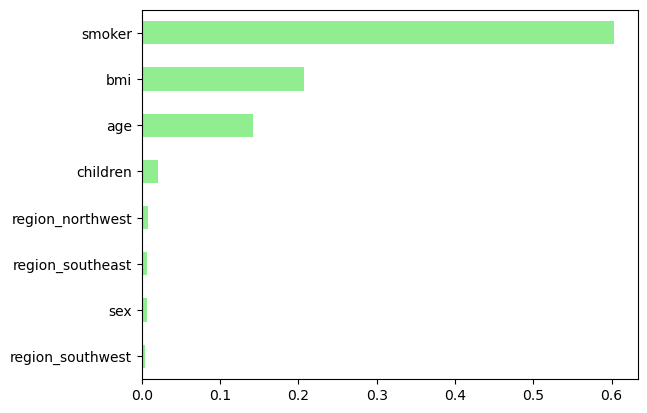

CV RMSE 4830.7921792782045
R2 0.8605689950982236


In [26]:
importances = pd.Series(rf.feature_importances_, index = x.columns)
sort = importances.sort_values()
sort.plot(kind = 'barh', color = 'lightgreen')
plt.show()
print('CV RMSE', np.sqrt(abs(cv_results.mean())))
print('R2', rf.score(x_test_s, y_test))


We see a smaller RMSE for Random Forest.

There could be a possibility that these models are overfitting beacuse of memorising noises from less informative features, since we have minimal features we will not explore the PCA, we will do it manually but with the help of RFE.

Sex and region are not very informative for this model

In [27]:
n = [1, 2, 3, 4, 5, 6, 7, 8]

for n in n:
    rfr = RFE(estimator = rf, n_features_to_select = n, verbose = 0)
    rfr.fit(x_train_s, y_train)
    print(f'R2 for {n} features', rfr.score(x_test_s, y_test))

R2 for 1 features 0.6719532367456491
R2 for 2 features 0.6916531354343123
R2 for 3 features 0.8554785103017137
R2 for 4 features 0.8555982204713999
R2 for 5 features 0.8599971336778318
R2 for 6 features 0.8602446246772004
R2 for 7 features 0.8592442196107111
R2 for 8 features 0.8589054982743696


We can go with 4 features or if don't want to lose much information 6 would be better!

#### Gradient Boosting

In [28]:
# Create and fit the Linear Regression model
gb = GradientBoostingRegressor()
gb.fit(x_train_s, y_train)

# Calculate cross-validated RMSE
cv_results = cross_val_score(gb, x_train_s, y_train, cv=10, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(abs(cv_results.mean()))

# Calculate RMSE for train set
train_rmse = np.sqrt(mean_squared_error(y_train, gb.predict(x_train_s)))

# Calculate RMSE for test set
test_rmse = np.sqrt(mean_squared_error(y_test, gb.predict(x_test_s)))

# Display results with proper spacing
print("Cross-Validated RMSE:", cv_rmse)
print("Train Set RMSE:", train_rmse)
print("Test Set RMSE:", test_rmse)
print("R2 Score:", gb.score(x_test_s, y_test))

Cross-Validated RMSE: 4512.243302565496
Train Set RMSE: 3694.4832364981335
Test Set RMSE: 4167.451544448602
R2 Score: 0.8790976174538719


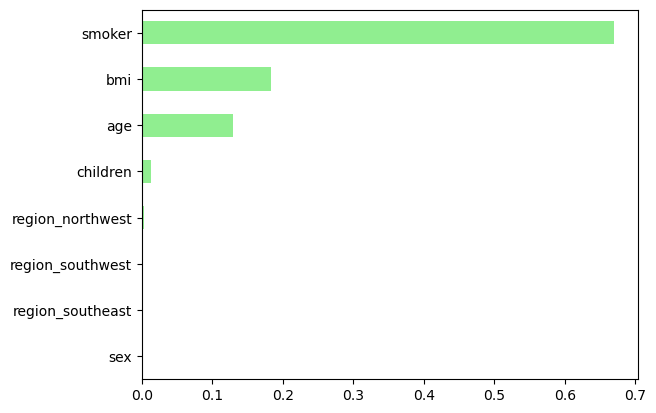

CV RMSE 4512.243302565496
R2 0.8790976174538719


In [29]:
importances = pd.Series(gb.feature_importances_, index = x.columns)
sort = importances.sort_values()
sort.plot(kind = 'barh', color = 'lightgreen')
plt.show()
print('CV RMSE', np.sqrt(abs(cv_results.mean())))
print('R2', gb.score(x_test_s, y_test))

A much smaller RMSE and a higher R2 is observed. Gradient Boosting disregards region and sex not fit for this predictive model!

In [30]:
n = [1, 2, 3, 4, 5, 6, 7, 8]

for n in n:
    gbr = RFE(estimator = gb, n_features_to_select = n, verbose = 0)
    gbr.fit(x_train_s, y_train)
    print(f'R2 for {n} features', gbr.score(x_test_s, y_test))
    print(f'RMSE',np.sqrt(mean_squared_error(y_test, gbr.predict(x_test_s))))

R2 for 1 features 0.67195890526262
RMSE 6864.631921917985
R2 for 2 features 0.7888853115361532
RMSE 5506.9654861660065
R2 for 3 features 0.879770324993466
RMSE 4155.841406680595
R2 for 4 features 0.8815140499652525
RMSE 4125.594665372655
R2 for 5 features 0.8813454377204412
RMSE 4128.529099686083
R2 for 6 features 0.8825208461451655
RMSE 4108.029316168812
R2 for 7 features 0.8816094304904263
RMSE 4123.933790774383
R2 for 8 features 0.8790976174538719
RMSE 4167.451544448602


We can see that using 6 or 4 features is giving optimal results for Gradient Boost!

#### Tuning

We are going to tune Gradient Boosting Regressor.

In [31]:
# Define the hyperparameter grid to search
params = {
    'n_estimators': [100, 200, 300],      # Number of boosting stages
    'learning_rate': [0.01, 0.1, 0.2],    # Step size at each iteration
    'max_depth': [3, 4, 5],               # Maximum depth of individual trees
    'subsample': [0.8, 1.0]               # Fraction of samples used for fitting each tree
}

# Create the GridSearchCV instance
random_search = RandomizedSearchCV(estimator=gb, param_distributions=params, cv=10, scoring='neg_mean_squared_error')

# Fit the GridSearchCV instance on your data
random_search.fit(x_train_s, y_train)

# Get the best parameters and the best model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

# Predict on the test set using the best model
y_pred = best_model.predict(x_test_s)

# Calculate RMSE on the test set
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print the best parameters and test RMSE
print("Best Parameters:", best_params)
print("Test Set RMSE with Best Model:", test_rmse)


Best Parameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.01}
Test Set RMSE with Best Model: 4359.621758877518


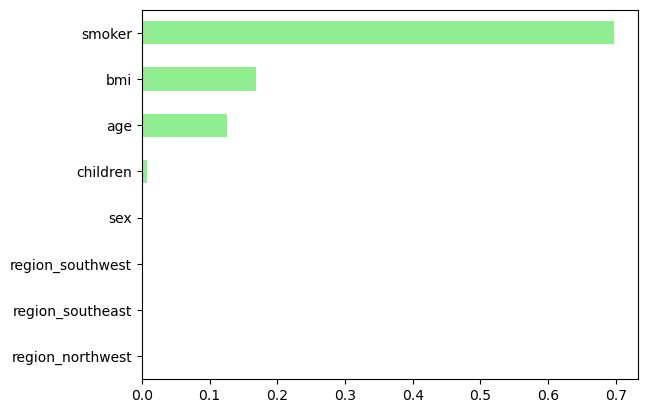

R2 0.8676903975804323


In [32]:
importances = pd.Series(best_model.feature_importances_, index = x.columns)
sort = importances.sort_values()
sort.plot(kind = 'barh', color = 'lightgreen')
plt.show()
print('R2', best_model.score(x_test_s, y_test))

In [33]:
n = [1, 2, 3, 4, 5, 6, 7, 8]

for n in n:
    gbr2 = RFE(estimator = best_model, n_features_to_select = n, verbose = 0)
    gbr2.fit(x_train_s, y_train)
    print(f'R2 for {n} features', gbr2.score(x_test_s, y_test))
    print(f'RMSE', np.sqrt(mean_squared_error(y_test, gbr2.predict(x_test_s))))

R2 for 1 features 0.6448300670700857
RMSE 7142.844998103679
R2 for 2 features 0.7874175666938994
RMSE 5526.075525850088
R2 for 3 features 0.8666711653463823
RMSE 4376.381473624998
R2 for 4 features 0.868060818303592
RMSE 4353.514771609928
R2 for 5 features 0.8676118188830183
RMSE 4360.9161568058
R2 for 6 features 0.8676903975804322
RMSE 4359.621758877518
R2 for 7 features 0.8676903975804322
RMSE 4359.621758877518
R2 for 8 features 0.8676903975804322
RMSE 4359.621758877518


For tuned and untuned Gradient Boosting models we seem to get the least RMSE and the highest test set Scores at 4 and 6. Lets see which features are these.

In [34]:
n = [4, 6]

for n in n:
    gbr3 = RFE(estimator = best_model, n_features_to_select = n, verbose = 0)
    gbr3.fit(x_train_s, y_train)
    print(f'{n} Features', x.loc[:, gbr3.support_].columns)

4 Features Index(['age', 'bmi', 'children', 'smoker'], dtype='object')
6 Features Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region_southwest'], dtype='object')


Age, BMI, Children, and Smoker seem to have more influence on medical charges.

### Conclusion

##### Best model, parameters, and optimal features

In [35]:
print('Model:', best_model)
print('Parameters:', best_params)
gbr4 = RFE(estimator = best_model, n_features_to_select = 4, verbose = 0)
gbr4.fit(x_train_s, y_train)
print('4 Features', x.loc[:, gbr4.support_].columns)

Model: GradientBoostingRegressor(learning_rate=0.01, n_estimators=200)
Parameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.01}
4 Features Index(['age', 'bmi', 'children', 'smoker'], dtype='object')
